In [ ]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math

In [ ]:
tracks = pickle.load(open("mario_tracks.pkl"))

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for trackID in sorted(tracks[0]):
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
track = track[:1000,:]
plt.plot(track[:,0],256-track[:,2])
plt.show()


In [ ]:
def jumps(vals):

    return [t for t in range(1,len(vals)) if  np.abs(vals[t]-vals[t-1]) > 1]
def samey_intervals(vals, t_window=5):

    last = vals[0]

    start = -1

    accum = 0

    intervals = []

    for t, v in enumerate(vals):

        if v != last:

            accum += 1

        if last == v:

            accum = 0

        if accum > 1:

            last = v

            if (t-accum)-start > t_window:

                intervals.append(start+1)

                intervals.append(t-accum)

                intervals.append(t-accum+1)

            start = t-accum

            accum = 0

    return intervals





def zero_crossings(vals):

    

    sign_intervals = []

    last_sign_change = 0

    vsigns = np.sign(vals)

    last_sign = vsigns[0]

    

    zeros = np.zeros(vsigns.shape)

    zeros[vsigns == 0] = 1

    accum = 0

    for t in range(len(zeros)):

        if zeros[t] == 1:

            accum += 1

        else:

            accum = 0

        zeros[t] = accum

    last = 0

    for t,v in enumerate(zeros):

        if v == 1:

            sign_intervals.append(t)

        elif v == 0 and last > 5:

            sign_intervals.append(t-1)

        last = v

    return sorted(set(sign_intervals))

In [ ]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 6

switch_points = set(zero_crossings(velocities))

samey_points = set(samey_intervals(velocities,t_window=same_window))

velocity_times = sorted(switch_points | samey_points | set(jumps(velocities)))

print len(velocity_times)

plt.plot(track[:,2])
plt.plot(np.array(velocity_times),track[np.array(velocity_times,dtype='int'),2],'rx')


import fceulib
inputVec = fceulib.readInputs('Illustrative.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    # Note: for a temporary optimization we could drop certain buttons?
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t-track[0,0])
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)
all_times = sorted(set(button_times) | set(velocity_times))
plt.plot(np.array(button_times),track[np.array(button_times),axis],'rx')
plt.show()

In [ ]:
def make_inputs(start,end,input_type):
    end = all_times[end]
    start = all_times[start]
    interval = end-start
    data = np.zeros((interval,1))
    
    if input_type in ['cN','accN']:
        data = np.hstack((data,np.ones((interval,1))))
    if input_type in ['acc0','accP','accN']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
            
        data = np.hstack((data,dat))
    if input_type in ['accP','cP']:
        begin = velocities[start]
        
        data = np.hstack((data,np.ones((interval,1))*begin))
    return data, velocities[start:end]

In [ ]:
%%time
import statsmodels.api as sm

all_times = [t for t in all_times if (t >= 0 and t < len(velocities))]

likes = [None]*len(all_times)

print "Points:",len(all_times)
print all_times
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 1 

likes = [None]*len(all_times)
for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        models = {}
        if all_times[j]-all_times[i] > 1:
            for model in ['c0','cN','acc0','accN']:
                X,Y = make_inputs(i,j,model)
                ols = sm.OLS(Y,X,hasconst=False)
                results = ols.fit()
                models[model] = results
        likes[i][j] = models

#print ''

In [50]:

modes = [(0,None)]*(len(all_times))
cost_weight = 10


for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    for i in range(0, j):
        data = likes[i][j]
        if data:
            for model_type,model in data.items():
                crit = model.bic
                if crit < 0:
                    #print 'A',(all_times[j]-all_times[i]),np.log(all_times[j]-all_times[i])*len(model.params)
                    crit = -1*(all_times[j]-all_times[i]) + np.log(all_times[j]-all_times[i])*len(model.params)
                    
                m_prev = modes[i][0]

                cost = np.log(all_times[j]-all_times[i])*cost_weight

                here = crit + m_prev + cost
                #print all_times[i], crit, cost,here
                if here < least:
                    
                    least = here
                    # prev_i,this_j,t0,t1,name,summary,criterion
                    least_template = (i,j,(model_type,model))
                    
    modes[j] = (least, least_template)

In [51]:
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',all_times[p[1][0]],all_times[p[1][1]],p[1][2][1].params,'\n'

0 -54.9224625561 
0 59 [ 0.] 

1 -55.536168195 
59 61 [ 0. -4.] 

2 -49.4942713025 
61 65 [ 0.   -3.75] 

3 -36.6190176641 
65 80 [ 0.         -3.15833333  0.11785714] 

4 -36.5395761224 
80 82 [ 0. -2.  1.] 

5 -37.1532817613 
82 84 [ 0. -1.] 

6 -28.8439882548 
84 93 [ 0.          0.40196078] 

7 -23.1675731295 
93 105 [ 0.          4.08333333] 

8 -29.9703485521 
105 114 [ 0.] 

9 -22.9958128406 
114 120 [ 0.         -3.83333333] 

10 -24.7769370157 
120 125 [ 0. -3.] 

11 -24.697495474 
125 127 [ 0. -3.  1.] 

12 -4.48659539808 
127 137 [ 0.         -2.54545455  0.12121212] 

13 -7.59477509997 
137 144 [ 0. -1.] 

14 -4.04669192491 
144 154 [ 0.          0.33684211] 

15 1.62972320046 
154 166 [ 0.          4.08333333] 

16 1.70916474214 
166 168 [ 0.  5. -4.] 

17 -2.49907578863 
168 174 [ 0.] 

18 4.47545992292 
174 180 [ 0.         -3.83333333] 

19 2.69433574779 
180 185 [ 0. -3.] 

20 2.77377728947 
185 187 [ 0. -2. -1.] 

21 7.87378858704 
187 190 [ 0.         -1.66666667] 



In [52]:
cross = {}

for ii,mode in enumerate(path):
    model1 = mode[1][2][1]
    model1_type = mode[1][2][0]
    model1_params = model1.params
    model1 = model1.model
    for jj,mode2 in enumerate(path):
        model2 = mode2[1][2][1]
        model2_type = mode2[1][2][0]
        model2_params = model2.params
        model2 = model2.model
        if model1_type == model2_type:
            crit = -model2.loglike(model1_params)
            if crit == float('-inf'):
                crit = -1*(all_times[mode[1][1]]-all_times[mode[1][0]])
        else:
            crit = float('inf')
        cross[(ii,jj)] = crit

In [53]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

In [54]:
cost_weight = 2
unions = UnionFind()
for d in sorted(cross):
    
    t1 = all_times[path[d[0]][1][1]]-all_times[path[d[0]][1][0]]
    t2 = all_times[path[d[1]][1][1]]-all_times[path[d[1]][1][0]]
    complexityWeight = cost_weight * (np.log(t1*t2)*len(path[d[0]][1][2][1].params))
    good = True
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
    joinedWeight = cost_weight * (np.log(t1+t2)*len(path[d[0]][1][2][1].params))
    #print path[d[0]][1][2][1].params,path[d[1]][1][2][1].params
    #print min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])]),joinedWeight, (cross[(d[0],d[0])]+cross[(d[1],d[1])]) , complexityWeight 
    
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])]) +joinedWeight
    
    if (joined <= (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
        
merged = {}
for u in unions:
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print len(merged)
for m in merged:
    print m, merged[m]

19
96 set([64, 96, 66, 100, 133, 103, 76, 77, 50, 117, 125, 126])
65 set([65])
2 set([1, 2, 131, 132, 5, 129, 9, 10, 13, 18, 19, 21, 33, 34, 47, 53, 54, 55, 56, 60, 61, 62, 70, 71, 72, 73, 130, 81, 82, 83, 84, 91, 92, 93, 94, 95, 105, 106, 107, 108, 112, 113, 114, 115, 123])
75 set([75])
4 set([4])
8 set([0, 32, 69, 39, 8, 74, 45, 111, 80, 17, 128, 52, 86, 121, 104, 26, 59, 90, 101])
11 set([11])
12 set([98, 3, 102, 40, 41, 12, 46, 48, 124, 35, 116, 122, 27, 28])
14 set([37, 6, 43, 14, 49, 110, 23, 57, 87, 30])
15 set([97, 67, 38, 7, 44, 78, 15, 88, 119, 24, 120, 58, 79, 31])
16 set([16])
99 set([99])
51 set([51])
20 set([20])
118 set([118])
89 set([89])
68 set([25, 68])
29 set([36, 42, 109, 85, 22, 29, 63])
127 set([127])


{96: 0, 65: 1, 2: 2, 11: 6, 4: 4, 51: 12, 8: 5, 75: 3, 12: 7, 14: 8, 15: 9, 16: 10, 99: 11, 20: 13, 118: 14, 89: 15, 127: 18, 29: 17, 68: 16}
0 59 5 [ 0.         -2.52471838]
59 61 2 [ 0.         -2.52471838]
61 65 2 [ 0.         -2.52471838]
65 80 7 [ 0.          4.07409091]
80 82 4 [ 0. -2.  1.]
82 84 2 [ 0.         -2.52471838]
84 93 8 [ 0.]
93 105 9 [ 0.         -2.52471838]
105 114 5 [ 0.         -2.52471838]
114 120 2 [ 0.         -2.52471838]
120 125 2 [ 0.         -2.52471838]
125 127 6 [ 0.          0.39186262]
127 137 7 [ 0.          4.07409091]
137 144 2 [ 0.         -2.52471838]
144 154 8 [ 0.]
154 166 9 [ 0.         -2.52471838]
166 168 10 [ 0.         -2.52471838]
168 174 5 [ 0.         -2.52471838]
174 180 2 [ 0.         -2.52471838]
180 185 2 [ 0.         -2.52471838]
185 187 13 [ 0.         -2.52471838]
187 190 2 [ 0.         -2.52471838]
190 192 17 [ 0.]
192 199 8 [ 0.]
199 207 9 [ 0.         -2.52471838]
207 209 16 [ 0.  5. -4.]
209 215 5 [ 0.         -2.52471838]
21

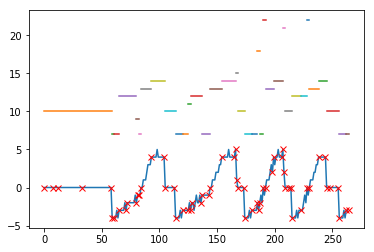

In [55]:
all_times2 = all_times[:60]
plt.plot(velocities[all_times2[0]:all_times2[-1]])
plt.plot(np.array(all_times2)-all_times2[0],velocities[np.array(all_times2,dtype='int')],'rx')

m2i = {m:i for i,m in enumerate(merged)}
print m2i
colors = ['r','g','b','c','m','y','k','#ff8800','#0088ff','#ff0088','#88ff00','#00ff88','#8800ff']
merged_params = {}
for m in merged:
    models = sorted(merged[m])
    sub = models[0]
    interval = path[sub][1][1]-path[sub][1][0]
    params =  path[sub][1][2][1].params*interval
    
    total = interval
    for sub in models[1:]:
        interval = path[sub][1][1]-path[sub][1][0]
        params +=  path[sub][1][2][1].params*interval
        total += interval
    merged_params[m] = params/float(total)

for u in sorted(unions):
    t0 = all_times[path[u][1][0]]-all_times2[0]
    t1 = all_times[path[u][1][1]]-all_times2[0]
    u = m2i[unions[u]]
    if t0 < all_times2[-1]-all_times2[0] and t1 >= 0:
        print t0, t1, u,merged_params[unions[u]]
        plt.plot([t0,t1],[u+5,u+5])#,colors[u])
        
        
plt.show()
